In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, TensorDataset

from model.CNN import CNN
from model.LSTM import LSTM
from libs import utils

%matplotlib inline

In [2]:
np.random.seed(42)
device = 'cuda:2' if torch.cuda.is_available() else 'cpu'
device

'cuda:2'

In [3]:
data_dir = 'data/beijing_data.csv'
transformed_data = utils.beijing_preprocess(data_dir)

In [4]:
train, valid, test = utils.beijing_data_split(transformed_data)
(X_train, y_train), (X_valid, y_valid), (X_test, y_test), test_scaler = utils.beijing_data2tensor(train, valid, test)

100%|██████████| 8735/8735 [00:21<00:00, 405.63it/s]


In [5]:
print('X Train shape ', X_train.shape)
print('X Valid shape ', X_valid.shape)
print('X Test shape', X_test.shape)

X Train shape  torch.Size([26279, 8, 24])
X Valid shape  torch.Size([8735, 8, 24])
X Test shape torch.Size([8735, 8, 24])


In [6]:
X_train

tensor([[[-1.0133, -1.0133, -1.0133,  ..., -1.0133, -1.0133, -1.0133],
         [-1.5753, -1.5753, -1.5753,  ..., -1.3002, -1.3002, -1.3002],
         [-1.8585, -1.9391, -1.8585,  ..., -1.3749, -1.3749, -1.3749],
         ...,
         [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  3.0000],
         [-0.0761, -0.0761, -0.0761,  ..., -0.0761, -0.0761, -0.0761],
         [-0.1424, -0.1424, -0.1424,  ..., -0.1424, -0.1424, -0.1424]],

        [[-1.0133, -1.0133, -1.0133,  ..., -1.0133, -1.0133,  0.4262],
         [-1.5753, -1.5753, -1.5753,  ..., -1.3002, -1.3002, -1.2314],
         [-1.9391, -1.8585, -2.1004,  ..., -1.3749, -1.3749, -1.2942],
         ...,
         [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  3.0000,  2.0000],
         [-0.0761, -0.0761, -0.0761,  ..., -0.0761, -0.0761, -0.0761],
         [-0.1424, -0.1424, -0.1424,  ..., -0.1424, -0.1424, -0.1424]],

        [[-1.0133, -1.0133, -1.0133,  ..., -1.0133,  0.4262,  0.6382],
         [-1.5753, -1.5753, -1.5065,  ..., -1

In [7]:
batch_size = 256

train_data = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_data, shuffle=False, batch_size=batch_size)

valid_data = TensorDataset(X_valid, y_valid)
valid_loader = DataLoader(valid_data, shuffle=False, batch_size=batch_size)

test_data = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_data, shuffle=False, batch_size=1)

# Model

In [8]:
def choose_model(model_type):
    if model_type == 'singleLSTM':
        model = LSTM(8, 128, 1, 24, 1).to(device)
        save_path = 'results/singleLSTM/'
        save_file_name = save_path + 'SingleLSTMbeijing.pth'
    elif model_type == 'stackedLSTM':
        model = LSTM(8, 128, 1, 24, 2).to(device)
        save_path = 'results/stackedLSTM/'
        save_file_name = save_path + 'StackedLSTMbeijing.pth'
    elif model_type == 'CNN':
        model = CNN(8, [32, 64, 128], 1).to(device)
        save_path = 'results/CNN/'
        save_file_name = save_path + 'CNNbeijing.pth'
    return model, save_path, save_file_name

In [9]:
model_type = 'CNN'
model, save_path, save_file_name = choose_model(model_type)
print(model)

CNN(
  (block1): Sequential(
    (0): Conv1d(8, 32, kernel_size=(4,), stride=(1,), padding=(1,))
    (1): ReLU()
  )
  (block2): Sequential(
    (0): Conv1d(32, 64, kernel_size=(4,), stride=(1,), padding=(1,))
    (1): ReLU()
  )
  (block3): Sequential(
    (0): Conv1d(64, 128, kernel_size=(4,), stride=(1,), padding=(1,))
    (1): ReLU()
  )
  (conv1): Conv1d(128, 1, kernel_size=(1,), stride=(1,))
)


In [10]:
lr = 0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                                       mode='min',
                                                       factor=0.2
                                                    )
criterion = nn.MSELoss().cuda()
patience = 5
n_epochs = 300

In [11]:
with torch.no_grad():
    dataiter = iter(train_loader)
    X, y = dataiter.next()
    print(X.shape)
    print(y.shape)
    X = X.reshape(-1, 24, 8)
    print(X)
    exmodel = LSTM(8, 40, 1, 24, 1).cuda()
    output = exmodel(X.cuda())
    criterion = nn.MSELoss().cuda()
    print(output.shape)
    print(output)
    loss = criterion(output.reshape(-1), y.cuda())
    print(loss)

torch.Size([256, 8, 24])
torch.Size([256])
tensor([[[-1.0133, -1.0133, -1.0133,  ..., -1.0133, -1.0133, -1.0133],
         [-1.0133, -1.0133, -1.0133,  ..., -1.0133, -1.0133, -1.0133],
         [-1.0133, -1.0133, -1.0133,  ..., -1.0133, -1.0133, -1.0133],
         ...,
         [-0.1424, -0.1424, -0.1424,  ..., -0.1424, -0.1424, -0.1424],
         [-0.1424, -0.1424, -0.1424,  ..., -0.1424, -0.1424, -0.1424],
         [-0.1424, -0.1424, -0.1424,  ..., -0.1424, -0.1424, -0.1424]],

        [[-1.0133, -1.0133, -1.0133,  ..., -1.0133, -1.0133, -1.0133],
         [-1.0133, -1.0133, -1.0133,  ..., -1.0133, -1.0133, -1.0133],
         [-1.0133, -1.0133, -1.0133,  ..., -1.0133, -1.0133,  0.4262],
         ...,
         [-0.1424, -0.1424, -0.1424,  ..., -0.1424, -0.1424, -0.1424],
         [-0.1424, -0.1424, -0.1424,  ..., -0.1424, -0.1424, -0.1424],
         [-0.1424, -0.1424, -0.1424,  ..., -0.1424, -0.1424, -0.1424]],

        [[-1.0133, -1.0133, -1.0133,  ..., -1.0133, -1.0133, -1.0133],
  

# Train

In [12]:
def fit(model, batch_size, patience, n_epochs):
    
    train_losses = []
    valid_losses = []
    avg_train_losses = []
    avg_valid_losses = []
    
    best_loss = 9999999999
    patience = 0
    
    for epoch in range(1, n_epochs + 1):

        ###################
        # train the model #
        ###################
        model.train()
        for data, target in train_loader:
            optimizer.zero_grad()
            if model_type != 'CNN':
                data, target = data.reshape(-1, 24, 8).cuda(), target.cuda()
            else:
                data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output.reshape(-1), target)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())

        ######################    
        # validate the model #
        ######################
        model.eval()
        for data, target in valid_loader:
            if model_type != 'CNN':
                data, target = data.reshape(-1, 24, 8).cuda(), target.cuda()
            else:
                data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output.reshape(-1), target)
            valid_losses.append(loss.item())

        train_loss = np.average(train_losses)
        valid_loss = np.average(valid_losses)
        avg_train_losses.append(train_loss)
        avg_valid_losses.append(valid_loss)
            
        epoch_len = len(str(n_epochs))
        
        print_msg = (f'[{epoch:>{epoch_len}}/{n_epochs:>{epoch_len}}] ' +
                     f'train_loss: {train_loss:.5f} ' +
                     f'valid_loss: {valid_loss:.5f}')
        
        print(print_msg)
        
        train_losses = []
        valid_losses = []
        
        if valid_loss < best_loss:
            best_loss = valid_loss
            patience = 0
            torch.save(model.state_dict(), save_file_name)
            print('Saving Model')
        else:
            patience += 1
            print('Patience for ', patience)
        if patience == 5:
            break

    model.load_state_dict(torch.load(save_file_name))

    return  model, avg_train_losses, avg_valid_losses

In [13]:
def evaluate_model(model, test_loader):
    test_loss = 0.0
    y_test = []
    y_hat = []
    model.eval()
    for data, target in test_loader:
        if model_type != 'CNN':
            data, target = data.reshape(-1, 24, 8).cuda(), target.cuda()
        else:
            data, target = data.to(device), target.to(device)
        y_test.append(target.cpu().numpy())
        output = model(data)
        y_hat.append(output.reshape(-1).detach().cpu().numpy())
        loss = criterion(output.reshape(1), target)
        test_loss += loss.item()
    return test_loss/len(test_loader), y_test, y_hat

In [14]:
model, train_loss, valid_loss = fit(model, batch_size, patience, n_epochs)

[  1/300] train_loss: 0.88213 valid_loss: 0.74680
Saving Model
[  2/300] train_loss: 0.63082 valid_loss: 0.55595
Saving Model
[  3/300] train_loss: 0.56664 valid_loss: 0.51728
Saving Model
[  4/300] train_loss: 0.53585 valid_loss: 0.50107
Saving Model
[  5/300] train_loss: 0.51369 valid_loss: 0.49061
Saving Model
[  6/300] train_loss: 0.50325 valid_loss: 0.48195
Saving Model
[  7/300] train_loss: 0.49604 valid_loss: 0.47470
Saving Model
[  8/300] train_loss: 0.48900 valid_loss: 0.46735
Saving Model
[  9/300] train_loss: 0.48132 valid_loss: 0.46002
Saving Model
[ 10/300] train_loss: 0.47292 valid_loss: 0.45242
Saving Model
[ 11/300] train_loss: 0.46355 valid_loss: 0.44470
Saving Model
[ 12/300] train_loss: 0.45329 valid_loss: 0.43678
Saving Model
[ 13/300] train_loss: 0.44158 valid_loss: 0.42790
Saving Model
[ 14/300] train_loss: 0.42742 valid_loss: 0.41510
Saving Model
[ 15/300] train_loss: 0.41165 valid_loss: 0.39918
Saving Model
[ 16/300] train_loss: 0.39614 valid_loss: 0.38288
Savin

In [15]:
test_loss, y_target, y_hat = evaluate_model(model, test_loader)

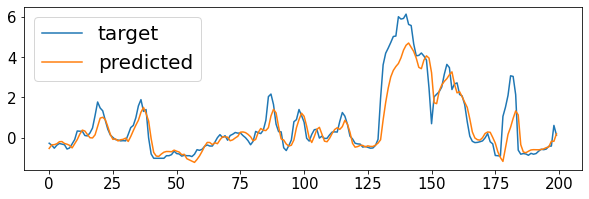

In [16]:
plt.figure(figsize=(10, 3))
plt.plot(y_target[200:400], label='target')
plt.plot(y_hat[200:400], label='predicted')
plt.legend(loc='upper left', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

In [17]:
print('Test Loss :', test_loss)

Test Loss : 0.11168792656963236
